# Basic characterizations of UA Q3
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qm.octave import QmOctaveConfig
from quam import QuAM

from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
#from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber
import xarray as xr

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 0 # for UA Q3
TLS_index = 0 # for TLS of interest
dc_flux_index = 2 # for dc line

2024-09-17 10:49:59,685 - qm - INFO     - Starting session: 0b02880a-4ccd-494a-a683-3842d2b5cbed


In [2]:
Analysis = AnalysisHandle("quam_state_q2.json")
machine = Analysis.get_machine()
Experiment = ExperimentHandle(machine)

In [3]:
# Set voltage of flux line to 0 V
for i in np.arange(7): 
    machine.dc_flux[i].dc_voltage = 0 + 0E6
machine = Analysis.set_machine(machine)

In [3]:
# initialize Labber-controlled hardware
# get values from QDAC first
#machine = Experiment.set_Labber.get_value_from_QDAC(machine)
# set all Labber settings
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
# set octave to external clock
#Experiment.set_octave.set_clock(machine)

In [4]:
# set to qubit
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [5]:
machine.octaves[0].LO_sources[1].gain = 0
machine = Analysis.set_machine(machine)

In [6]:
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q2 for (LO, IF) = (6.091 GHz, -50.000 MHz)
------------------------------------- Calibrates r2 for (LO, IF) = (7.054 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


# Qubit Readout

## Time of Flight

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 66.38s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0917\2024-09-17_q2_time_of_flight_3
DC offset to add to I: -0.000814 V
DC offset to add to Q: -0.000654 V
TOF to add: 0.0 ns


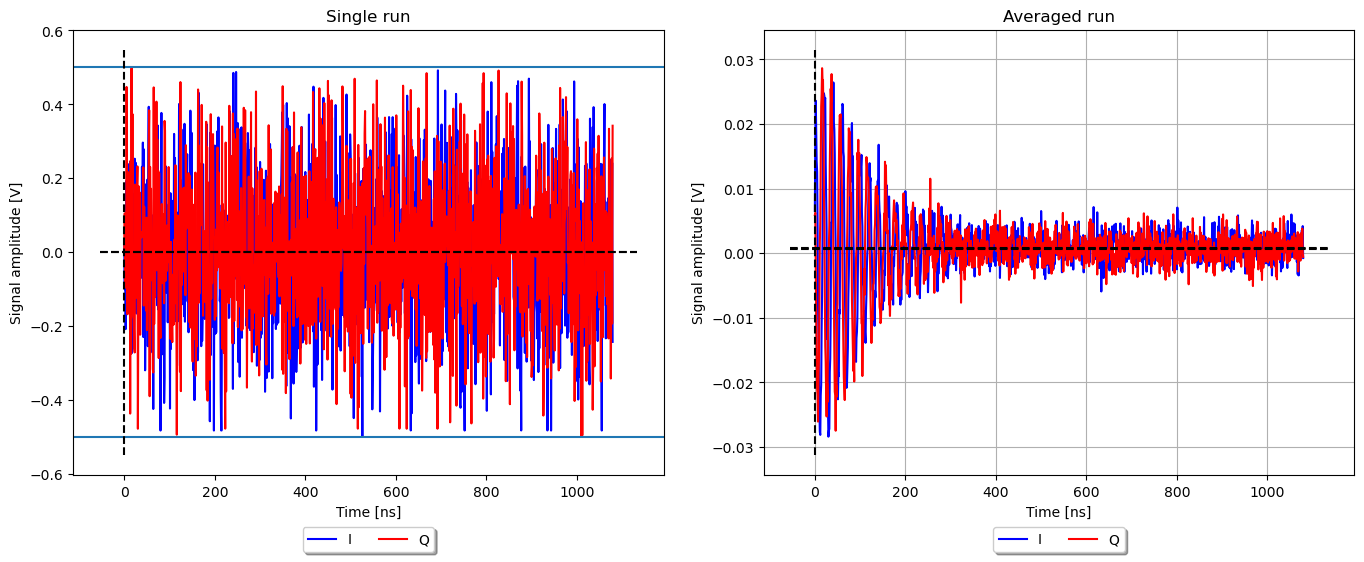

In [8]:
# time_of_flight
# experiment
%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.time_of_flight(machine,qubit_index, n_avg = 10E3, cd_time = 10E3, to_simulate = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(expt_dataset)

In [9]:
# update the offset
machine.global_parameters.downconversion_offset_I[0] += dc_offset_i
machine.global_parameters.downconversion_offset_Q[0] += dc_offset_q
machine.resonators[qubit_index].downconversion_offset_I = machine.global_parameters.downconversion_offset_I[0]
machine.resonators[qubit_index].downconversion_offset_Q = machine.global_parameters.downconversion_offset_Q[0]
machine.resonators[qubit_index].time_of_flight = 304
machine = Analysis.set_machine(machine)

In [10]:
## Change if it saturates
machine.global_parameters.downconversion_gain[0] = 0
machine.resonators[qubit_index].downconversion_gain = 0
machine = Analysis.set_machine(machine)

## Resonator spectroscopy

### 1D resonator spectroscopy

In [19]:
machine.resonators[qubit_index].readout_pulse_amp = 0.45

In [10]:
%matplotlib qt
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-5E6,5E6 + 1.0,0.05E6)
machine, expt_dataset = Experiment.exp1D.RR.rr_freq(machine, res_freq_sweep, qubit_index, n_avg = 5E3, cd_time = 10E3, live_plot = True,
                                                    readout_state = 'g', to_simulate = False, data_process_method = 'Amplitude')
# Readout in excited state
# machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
#                           n_avg = 1E3, cd_time = 5E3, readout_state = 'e', simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 11.34s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0917\2024-09-17_q2_res_spec_4
Execution stopped by user!


resonator frequency: 7003.800 MHz


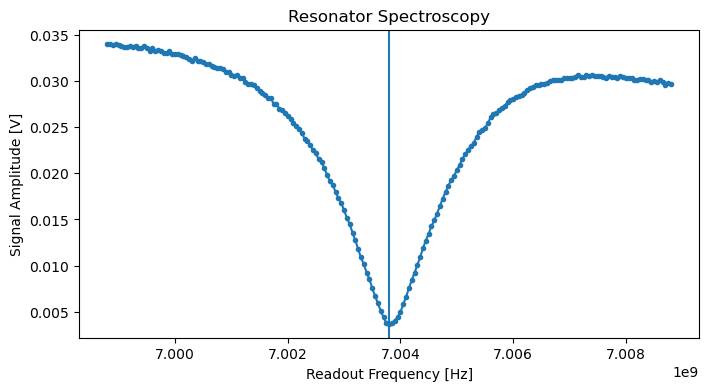

In [11]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(expt_dataset)
machine.resonators[qubit_index].f_readout = res_freq + 0E6

In [12]:
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q2 for (LO, IF) = (6.091 GHz, -50.000 MHz)
------------------------------------- Calibrates r2 for (LO, IF) = (7.054 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


### 2D resonator spectroscopy

In [18]:
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-6e6, 4e6, 0.1E6)
dc_flux_sweep = np.arange(-9,9.001,0.1)
%matplotlib qt
machine, expt_dataset = Experiment.exp2D.RR.rr_vs_dc_flux(machine, res_freq_sweep, dc_flux_sweep, qubit_index,
                                                          n_avg = 1E3, cd_time = 10E3, live_plot = True)

Progress: [##################################################] 100.0% (n=181/181) --> elapsed time: 365.02s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0917\2024-09-17_q2_res_spec2D
Execution stopped by user!


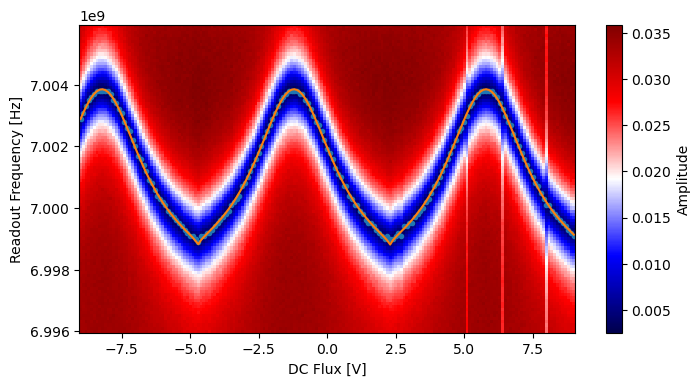

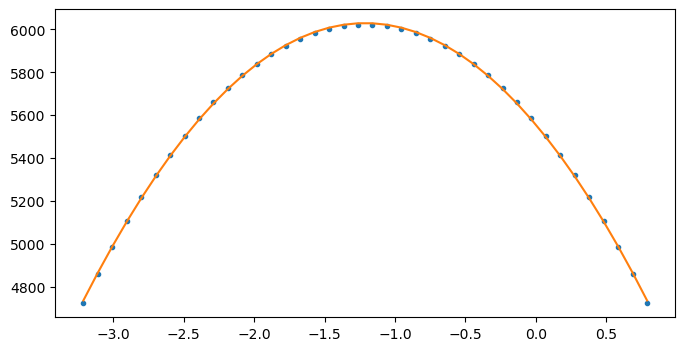

In [19]:
%matplotlib inline 
ham_param = Analysis.exp2D.rr_vs_dc_flux(expt_dataset, to_plot = True, init_guess = None)
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param = ham_param, to_plot = True)

In [20]:
# save the fitting parameters
machine.resonators[qubit_index].tuning_curve = ham_param
machine.qubits[qubit_index].DC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

In [21]:
# save the sweep spot flux according to fitted parameter
machine.dc_flux[dc_flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param)
machine = Analysis.set_machine(machine)

if 2D res spectroscopy is just to test the experiment, and I want to go back to sweet spot

In [22]:
machine = Analysis.update_machine_res_frequency_sweet_spot(machine, qubit_index, dc_flux_index) 
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50e6
machine.dc_flux[dc_flux_index].dc_voltage = machine.dc_flux[dc_flux_index].max_frequency_point
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
machine = Analysis.set_machine(machine)
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q2 for (LO, IF) = (6.091 GHz, -50.000 MHz)
------------------------------------- Calibrates r2 for (LO, IF) = (7.053 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


# Qubit Sweet Spot Calibrations

## 1D qubit spectroscopy @ sweep spot

In [18]:
if True: # for the DC flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.dc_flux[dc_flux_index].max_frequency_point) * 1E6 # in Hz
else: # for the fast flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz

qubit_freq_sweep = int(qubit_freq_est) + np.arange(-15E6, 25E6 + 1, 1E6)
    
%matplotlib qt
machine, expt_dataset = Experiment.exp1D.Rabi.qubit_freq(machine, qubit_freq_sweep, qubit_index, pi_amp_rel = 1.0, live_plot = True,
                                                         ff_amp = 0.0, n_avg = 1E4, cd_time = 30E3, to_simulate = False, data_process_method = 'Amplitude')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 13.07s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0917\2024-09-17_q2_spec_5
Execution stopped by user!


peak frequency:  6035.5 [MHz]


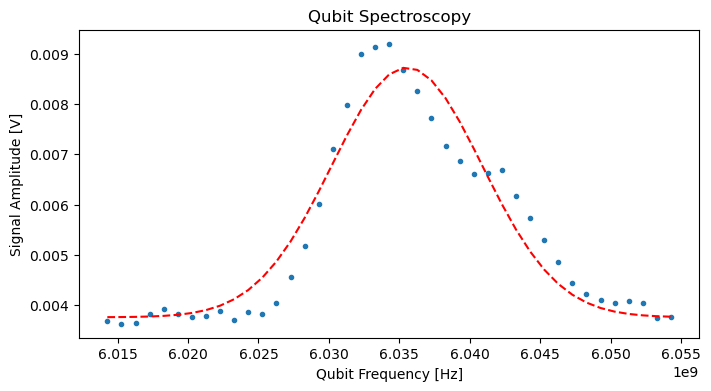

In [19]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(expt_dataset, method="Gaussian", data_process_method = 'Amplitude')
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6

In [27]:
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q2 for (LO, IF) = (6.091 GHz, -50.000 MHz)
------------------------------------- Calibrates r2 for (LO, IF) = (7.054 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


## Rabi

### Time Rabi

In [14]:
%matplotlib qt
rabi_duration_sweep = np.arange(16, 240 + 0.1, 4)  # in ns
machine, expt_dataset = Experiment.exp1D.Rabi.rabi_length(machine, rabi_duration_sweep, qubit_index, pi_amp_rel = 1.0, live_plot = True, 
                                                          n_avg = 10E3, cd_time = 25E3, to_simulate = False, data_process_method = 'I')

Execution stopped by user!                                   ] 28.5% (n=2854/10000.0) --> elapsed time: 4.28s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0917\2024-09-17_q2_time_rabi0/10000.0) --> elapsed time: 4.71s


rabi_pi_pulse: 100.3 [ns]
pi period: 98.41 [ns]


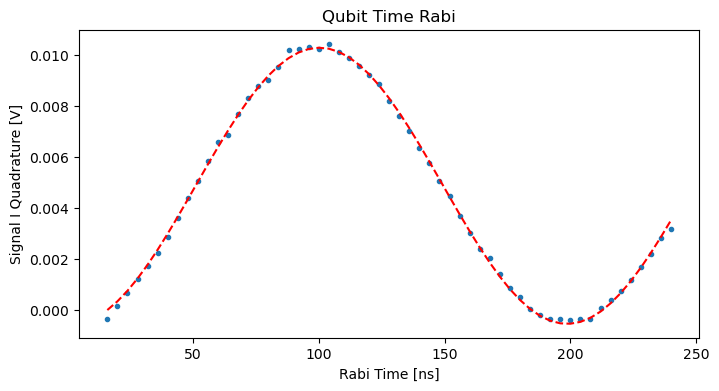

In [41]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(expt_dataset, method = "Sine", to_plot = True, data_process_method = 'I')

In [27]:
machine.qubits[qubit_index].pi_amp

0.03413408656860973

In [23]:
machine.qubits[qubit_index].pi_length = 200
machine.qubits[qubit_index].pi_amp = 0.034
machine = Analysis.set_machine(machine)


### Power Rabi

In [24]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.1, 2, 0.05) 
machine, expt_dataset = Experiment.exp1D.Rabi.rabi_amp(machine, rabi_amp_sweep_rel, qubit_index, ff_amp = 0.0, live_plot = True,
                                       n_avg = 5E4, cd_time = 20E3, data_process_method = 'Amplitude')

Execution stopped by user!                                   ] 18.0% (n=9010/50000.0) --> elapsed time: 7.17s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0917\2024-09-17_q2_power_rabi_40000.0) --> elapsed time: 7.49s


rabi_pi_amp: 0.036 [V]
pi period: 0.033 [V]


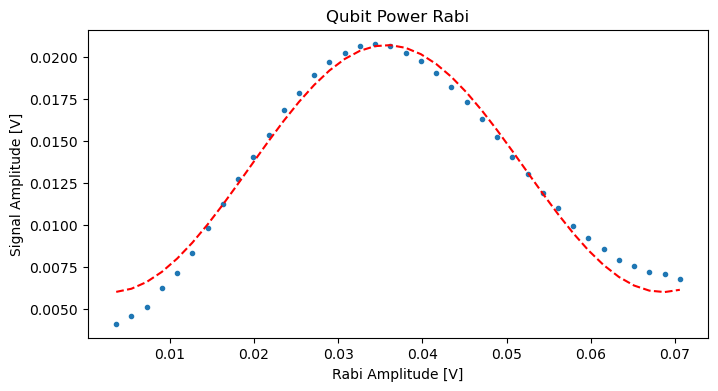

In [37]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(expt_dataset, method = "Sine", data_process_method = 'Amplitude')
machine.qubits[qubit_index].pi_amp = pi_pulse_amp
machine = Analysis.set_machine(machine)

## Single-Shot Readout

### Find frequency between g, e

In [42]:
%matplotlib qt
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-4E6,3E6 + 1.0,0.05E6)
machine, expt_dataset = Experiment.exp1D.RR.rr_freq_ge(machine, res_freq_sweep, qubit_index, n_avg = 1E4, cd_time = 10E3,
                                                    to_simulate = False, simulation_len = 1000, live_plot = True, data_process_method = 'Phase')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 31.62s
----------saved to Z:\QM_Data_DF5\2024\08\Data_0823\2024-08-23_q2_res_spec_ge
Execution stopped by user!


resonator frequency: 7003.300 MHz


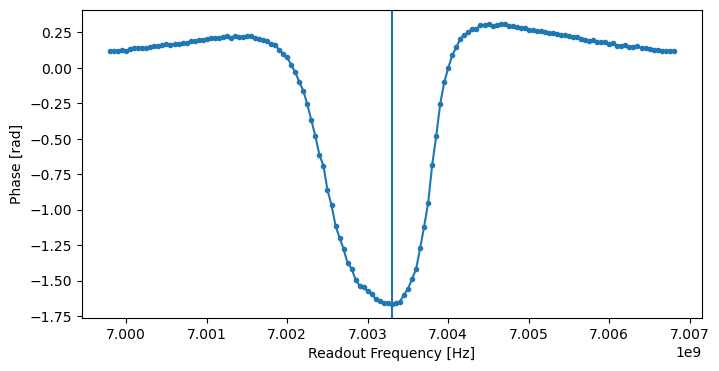

In [43]:
%matplotlib inline
res_freq_phase = Analysis.exp1D.rr_freq_ge(expt_dataset)

In [44]:
# doesn't have to update. Use res_freq_phase
# machine.resonators[qubit_index].f_readout = 6226119034 + 0E6
machine.resonators[qubit_index].f_readout = res_freq_phase + 0E6
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q2 for (LO, IF) = (6.091 GHz, -50.000 MHz)
------------------------------------- Calibrates r2 for (LO, IF) = (7.053 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


### IQ blobs

In [58]:
%matplotlib inline
machine, expt_dataset = Experiment.exp1D.RR.single_shot_IQ_blob(machine, qubit_index, n_avg = 30E3, cd_time = 25E3, final_plot = False)

----------saved to Z:\QM_Data_DF5\2024\08\Data_0823\2024-08-23_q2_single_shot_IQ_5--> elapsed time: 1.73s



			Fidelity Matrix:
			-----------------
			| 0.944 | 0.056 |
			----------------
			| 0.216 | 0.784 |
			-----------------
			IQ plane rotated by: 359.2°
			Threshold: 3.317e-03
			Fidelity: 86.4%
			


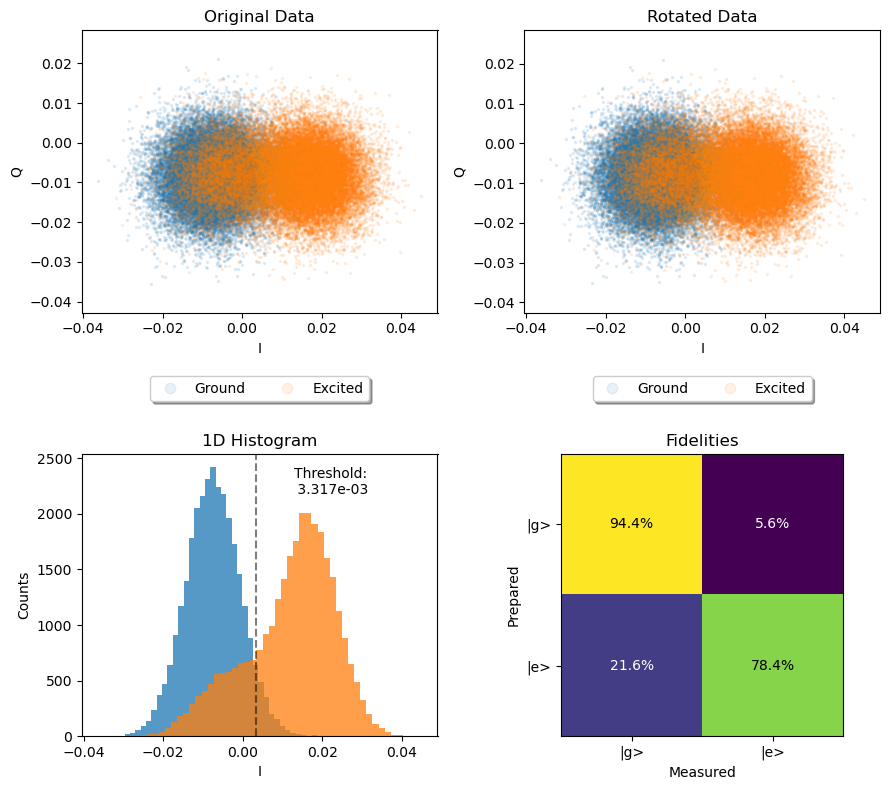

In [59]:
%matplotlib inline
angle, threshold, fidelity, gg, ge, eg, ee = Analysis.exp1D.two_state_discriminator(expt_dataset)

In [60]:
# set the rotation angle
machine.resonators[qubit_index].rotation_angle -= angle # note this is the change value not the absolute value!
machine.resonators[qubit_index].ge_threshold = threshold
machine = Analysis.set_machine(machine)

In [57]:
machine.resonators[qubit_index].readout_pulse_amp = 0.45
machine.resonators[qubit_index].readout_pulse_length = 1080
machine = Analysis.set_machine(machine)

### Readout freq optimization

In [68]:
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-1.5E6, 1.5E6 + 1, 0.05E6)

%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_freq_optimization(machine, res_freq_sweep, qubit_index, n_avg = 5E4, cd_time = 25E3, 
                                                           final_plot = True, live_plot = True)

Execution stopped by user!                                   ] 11.9% (n=5926/50000.0) --> elapsed time: 19.01s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0522\2024-05-22_q4_single_shot_freq.0) --> elapsed time: 19.27s
The optimal readout frequency is 6223722880.0 Hz (SNR=0.048823998479026236)


peak frequency:  6226.2 [MHz]


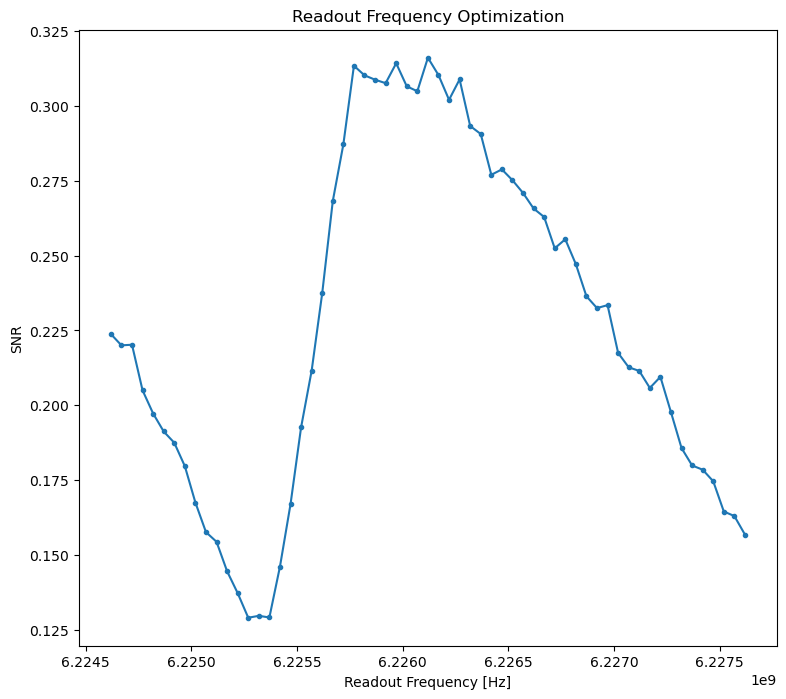

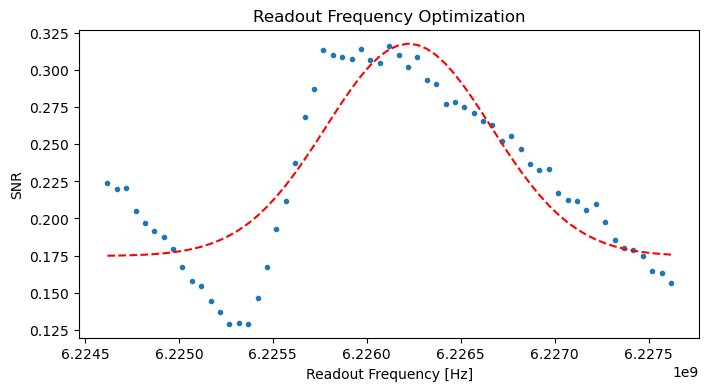

Execution stopped by user!


In [150]:
%matplotlib inline
res_freq = Analysis.exp1D.peak_fit(expt_dataset,method="Gaussian", data_process_method = 'SNR')

In [95]:
machine.resonators[qubit_index].f_readout = res_freq + 0E6
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Analysis.set_machine(machine)
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q4 for (LO, IF) = (5.762 GHz, -50.000 MHz)
------------------------------------- Calibrates r4 for (LO, IF) = (6.274 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


### Readout pulse amp and duration (by qubit relaxation during readout)

In [116]:
%matplotlib qt
res_duration_sweep_abs = np.arange(300, 2000 + 1, 20)
res_amp_sweep_abs = np.arange(0.15,0.45,0.001)
machine, expt_dataset = Experiment.exp2D.RR.rr_pulse_optimize(machine, res_duration_sweep_abs, res_amp_sweep_abs, qubit_index, n_avg=1E3, 
                                                              cd_time=25E3, live_plot = True, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 744.49s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0521\2024-05-21_q4_res_pulse_optimize


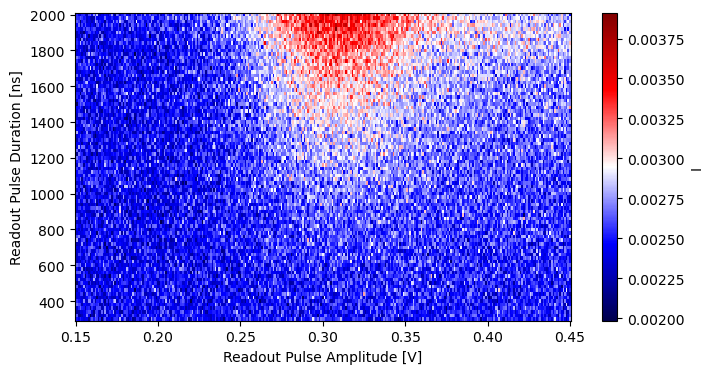

In [126]:
%matplotlib inline
data = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0521\2024-05-21_q4_res_pulse_optimize.nc")
data['I'].plot(x = list(expt_dataset.coords.keys())[0], y = list(expt_dataset.coords.keys())[1], cmap = "seismic")

In [69]:
machine.resonators[qubit_index].readout_pulse_amp = 0.45
machine.resonators[qubit_index].readout_pulse_length =1396
machine = Analysis.set_machine(machine)

### Readout duration optimization

In [67]:
division_length = 40
%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_duration_optimization(machine, division_length, qubit_index,
                                                                    readout_len = 2000, n_avg = 2E4, cd_time = 25E3)

Integration weights chunk-size length in ns: 40
The readout has been sliced in the following number of divisions 50
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.72s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.73s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.75s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.77s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.78s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.80s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.81s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed 

In [102]:
machine.resonators[qubit_index].readout_pulse_length = 1360
machine = Analysis.set_machine(machine)

### Readout amp optimization

In [99]:
res_amp_sweep = np.arange(0.5,1.5 + 1E-4, 0.01)

%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_amp_optimization(machine, res_amp_sweep, qubit_index,
                              n_avg = 5E3, cd_time = 25E3, final_plot= True)

some abs amps > 0.5, removed from experiment run
2024-05-21 16:17:16,725 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-05-21 16:17:16,749 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-05-21 16:17:16,773 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-05-21 16:17:16,795 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-05-21 16:17:16,817 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-05-21 16:17:16,839 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-05-21 16:1

peak voltage:  0.484 [V]


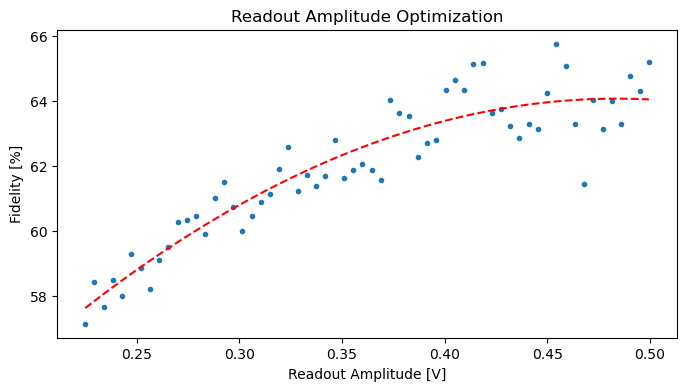

In [100]:
%matplotlib inline
readout_amp = Analysis.exp1D.peak_fit(expt_dataset, method="Gaussian", data_process_method = 'Fidelity')

In [ ]:
machine.resonators[qubit_index].readout_pulse_amp = 0.48
machine = Analysis.set_machine(machine)

## Qubit T1

In [61]:
%matplotlib qt
tau_sweep_abs = np.arange(100,30E3+1,1E3)
machine, expt_dataset = Experiment.exp1D.T1.qubit_T1(machine, tau_sweep_abs, qubit_index, n_avg = 1E4, cd_time = 40E3, live_plot = True,
                                                               to_simulate = False, simulation_len = 15_000, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 16.99s
----------saved to Z:\QM_Data_DF5\2024\08\Data_0823\2024-08-23_q2_T1


Qubit T1: 2.4 [us]


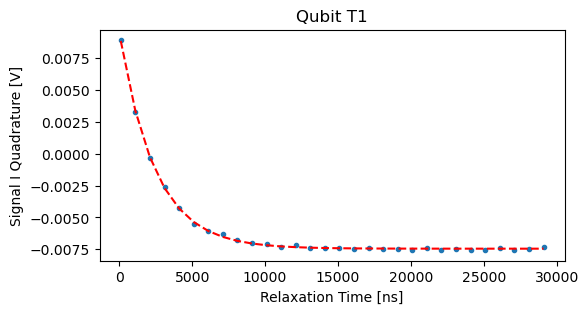

In [63]:
%matplotlib inline
qubit_T1 = Analysis.exp1D.T1(expt_dataset, data_process_method = 'I')
machine.qubits[qubit_index].T1 = qubit_T1
machine = Analysis.set_machine(machine)

## Qubit Ramsey

In [65]:
%matplotlib qt
ramsey_duration_sweep = np.arange(16, 3000 + 0.1, 20)  # in units of ns
machine, expt_dataset = Experiment.exp1D.Ramsey.ramsey(machine, ramsey_duration_sweep, qubit_index, detuning = 2E6, live_plot = True,
                                                       n_avg = 2E4, cd_time = 20E3, to_simulate = False, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 68.76s
----------saved to Z:\QM_Data_DF5\2024\08\Data_0823\2024-08-23_q2_ramsey_2


Qubit T2*:  1856.3 [ns]
Exponent n =  1.6
Detuning =  2.6 [MHz]


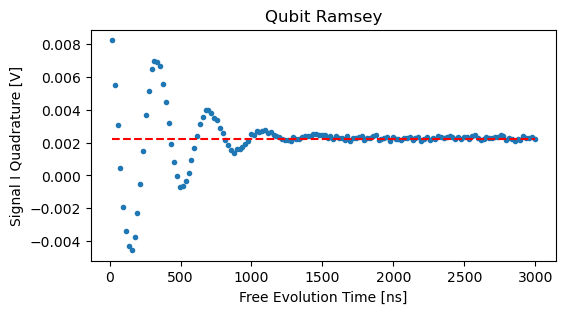

In [67]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(expt_dataset, data_process_method = 'I')
machine.qubits[qubit_index].T2 = q_T2star
machine = Analysis.set_machine(machine)

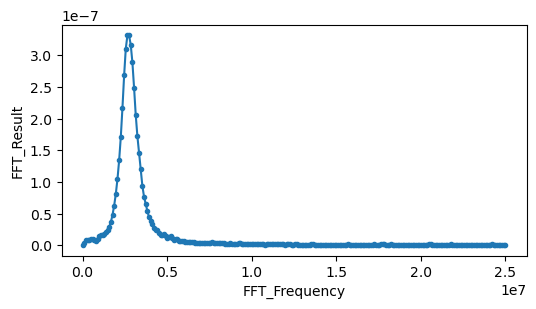

In [68]:
%matplotlib inline
fft_dataset = Analysis.exp1D.fft(expt_dataset, to_plot = True, data_process_method = 'I')

In [84]:
# Get the peak frequency
idx = fft_dataset['FFT_Result'].argmax().item()
max_freq = fft_dataset['FFT_Frequency'][idx].item()
max_freq

1956947.1624266144

## ef transition

### ef frequency

In [ ]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-190E6, -150E6 + 1, 0.5E6) 
machine, expt_dataset = Experiment.exp1D.Rabi.ef_freq(machine, ef_freq_sweep, qubit_index, pi_amp_rel_ef = 1.0, n_avg = 2E3, live_plot = True,
                                                      cd_time = 30E3, readout_state = 'g', to_simulate = False, data_process_method = 'I')

In [ ]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(expt_dataset, method="Gaussian", data_process_method = 'I')

In [ ]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - ef_freq
machine = Analysis.set_machine(machine)

### ef transition time Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(16, 240 + 0.1, 4)  # in ns
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, expt_dataset = Experiment.exp1D.Rabi.ef_rabi_length(machine, rabi_duration_sweep, qubit_index, pi_amp_rel_ef = 1.0, live_plot = True,
                                                                             n_avg = 2E3, cd_time = 30E3, readout_state = 'g', 
                                                                             to_simulate = False, simulation_len = 10_000, data_process_method = 'I')

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(expt_dataset, data_process_method = 'I')

In [ ]:
machine.qubits[qubit_index].pi_length_ef = 180
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 2.0, 0.025) 
machine, expt_dataset = Experiment.exp1D.Rabi.ef_rabi_amp(machine, rabi_amp_sweep_rel, qubit_index, n_avg = 2E3, cd_time = 30E3, live_plot = True,
                                                          readout_state = 'g', to_simulate = False, simulation_len = 1000, data_process_method = 'I')

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(expt_dataset, method = "Sine", data_process_method = 'I')

In [ ]:
machine.qubits[qubit_index].pi_amp_ef = pi_pulse_amp
machine = Analysis.set_machine(machine)

# Qubit Tuning Curves

## 2D qubit spectroscopy vs dc flux

In [69]:
# try the experiment
%matplotlib qt
dc_flux_sweep = machine.dc_flux[dc_flux_index].max_frequency_point + np.arange(-0.45,0.45+1E-4,0.02)
qubit_if_sweep = np.arange(-30E6, 30E6, 1E6)
machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(machine, dc_flux_sweep, qubit_if_sweep, qubit_index,
                                 n_avg = 1E3, cd_time = 20E3, final_plot = True, live_plot = True,  data_process_method = 'Amplitude')

Progress: [##################################################] 100.0% (n=46/46) --> elapsed time: 479.14s
----------saved to Z:\QM_Data_DF5\2024\08\Data_0823\2024-08-23_q2_res_spec_vs_dc_flux
----------saved to Z:\QM_Data_DF5\2024\08\Data_0823\2024-08-23_q2_qubit_spec_vs_dc_flux
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped 

In [92]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 2, to_plot = False, data_process_method = 'Amplitude')
machine.dc_flux[dc_flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param) + 0E1
print(f"sweet spot flux: {machine.dc_flux[dc_flux_index].max_frequency_point:.5f} V")

sweet spot flux: -0.79486 V


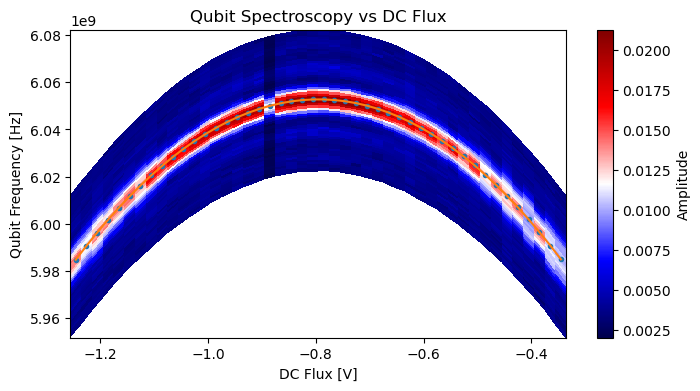

In [94]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 4, to_plot = True, data_process_method = 'Amplitude')
machine.qubits[qubit_index].DC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

In [95]:
# go to the sweet spot, if needed
machine.dc_flux[dc_flux_index].dc_voltage = machine.dc_flux[dc_flux_index].max_frequency_point
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
machine = Analysis.set_machine(machine)

In [96]:
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q2 for (LO, IF) = (6.103 GHz, -50.000 MHz)
------------------------------------- Calibrates r2 for (LO, IF) = (7.053 GHz, -49.578 MHz)
------------------------------------- Octave calibration finished.


## 2D qubit spectroscopy vs fast flux

In [17]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine.dc_flux[dc_flux_index].dc_voltage = machine.dc_flux[dc_flux_index].max_frequency_point
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
machine = Analysis.set_machine(machine)

### slow version, compiling 1D scans

In [101]:
# try the experiment
%matplotlib qt
#ff_sweep = np.arange(-0.02,-0.28-1E-4,-0.02)
ff_sweep = np.arange(0,0.25+1E-4,0.05)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 1E6)
machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(machine, ff_sweep,qubit_if_sweep,
      qubit_index, ff_to_dc_ratio = None, n_avg = 1E3, cd_time = 20E3)

Execution stopped by user!
------------------------------------- Octave calibration starts...7% (n=4/6) --> elapsed time: 19.81s
------------------------------------- Calibrates q2 for (LO, IF) = (5.496 GHz,  290.000 MHz)
2024-06-24 17:39:56,569 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-24 17:39:56,687 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-24 17:39:56,709 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-24 17:39:56,740 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-24 17:39:56,756 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more informatio

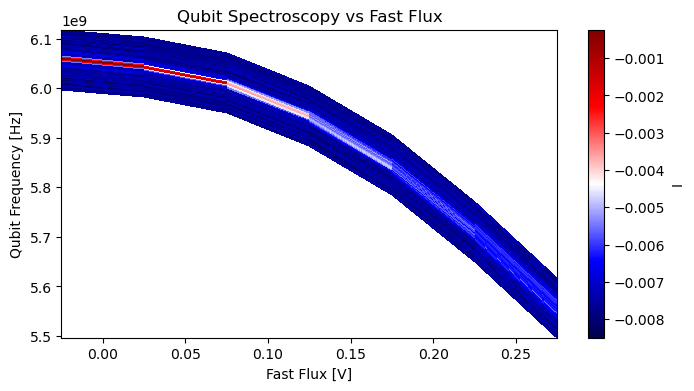

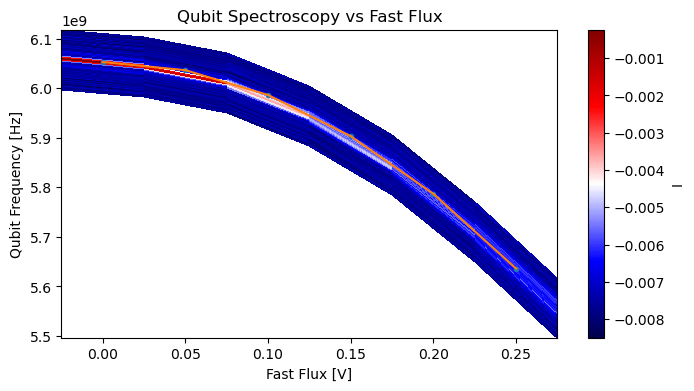

In [102]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 4, to_plot = True, data_process_method = 'I')
machine.qubits[qubit_index].AC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

### fast version, runs blockwise 2D sweeps

In [105]:
%matplotlib qt
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)
qubit_freq_sweep = np.arange(q_freq_max, 4.4E9, -5E6)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)
machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(machine, qubit_freq_sweep,qubit_if_sweep,
          qubit_index, n_avg = 4E3, cd_time = 20E3, final_plot = True, live_plot = True)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q2 for (LO, IF) = (5.753 GHz,  200.000 MHz)
2024-06-24 17:48:03,101 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-24 17:48:03,218 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-24 17:48:03,244 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-24 17:48:03,276 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-24 17:48:03,293 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-24 17:48:03,316 - qm - ERROR    - Runtime errors wer

In [109]:
%matplotlib qt
data = xr.load_dataset(r"Z:\QM_Data_DF5\2024\06\Data_0624\2024-06-24_q2_qubit_spec_vs_fast_flux_3.nc")
data['I'].plot(x = list(data.coords.keys())[0], y = list(data.coords.keys())[1], cmap = "seismic")

In [107]:
# save the fitted tuning curve
# %matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 4, to_plot = True, data_process_method = 'I')
machine.qubits[qubit_index].AC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

# TLS experiments

## TLS SWAP spectroscopy

In [113]:
# Go back to the sweet spot and calibrate
machine.qubits[qubit_index].f_01 = int(np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)) + 0E6
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [114]:
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q2 for (LO, IF) = (6.095 GHz, -50.000 MHz)
------------------------------------- Calibrates r2 for (LO, IF) = (7.053 GHz, -49.578 MHz)
------------------------------------- Octave calibration finished.


### coarse, no baking

In [33]:
%matplotlib qt
tau_sweep_abs = np.arange(16,100 + 0.1,1)
# ff_sweep_abs = np.arange(0.25,0.32,0.002)
ff_sweep_abs = np.arange(0.1,0.45,0.001)
machine, expt_dataset = Experiment.exp2D.SWAP.swap_coarse(machine, tau_sweep_abs, ff_sweep_abs, qubit_index, 
                      n_avg = 1E4, cd_time = 20E3, live_plot=True)

KeyboardInterrupt: 

### fine, with baking

In [116]:
%matplotlib qt
tau_sweep_abs = np.arange(4,160,1)
# ff_sweep_abs = np.arange(0.1,0.45+1E-4,0.0005)
ff_sweep_abs = np.arange(0.29,0.33,0.0005)
machine, expt_dataset = Experiment.exp2D.SWAP.swap(machine, tau_sweep_abs, ff_sweep_abs, qubit_index,
                      n_avg = 4E3, cd_time = 20E3, live_plot=True)

Execution stopped by user!#############                      ] 57.9% (n=2315/4000.0) --> elapsed time: 1211.28s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0625\2024-06-25_q2_swap2D_317/4000.0) --> elapsed time: 1212.68s


In [41]:
%matplotlib qt
expt_dataset['I'].plot(x = list(expt_dataset.coords.keys())[0], y = list(expt_dataset.coords.keys())[1], cmap = "seismic")

In [42]:
fft_dataset = Analysis.exp2D.SWAP_fft(expt_dataset, to_plot = True)

### Add TLS iswap params

In [43]:
expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0522\2024-05-22_q4_swap2D_4.nc")

SWAP plot, to find the SWAP param range for different TLS

In [44]:
%matplotlib qt
expt_dataset['I'].plot(x = list(expt_dataset.coords.keys())[0], y = list(expt_dataset.coords.keys())[1], cmap = "seismic")
plt.show()

initialize the iswap params in quam

In [45]:
machine.flux_lines[qubit_index].iswap.length =[]
machine.flux_lines[qubit_index].iswap.level = []

#### TLS0

In [46]:
flux_min, flux_max = (0.276,0.284)
interaction_time_min, interaction_time_max = (4,18)
flux_range = (flux_min, flux_max)
interaction_time_range = (interaction_time_min, interaction_time_max)

iswap flux level:  0.28100 [V]
iswap flux length:  10 [ns]


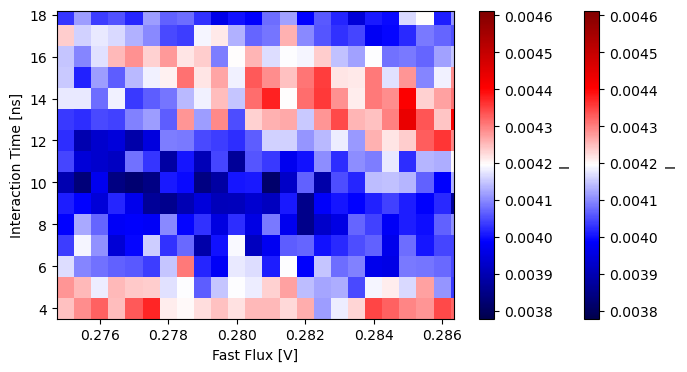

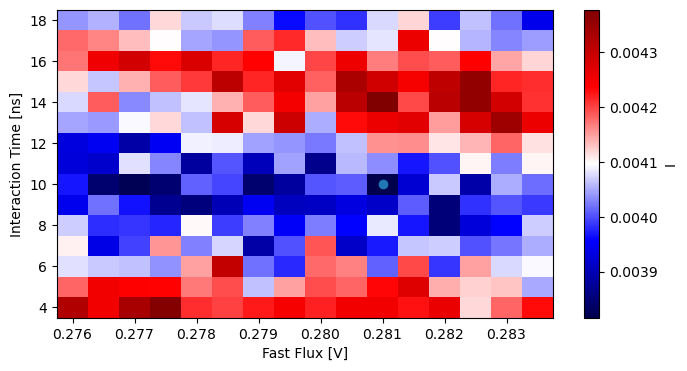

Execution stopped by user!


In [47]:
%matplotlib inline
iswap_flux, iswap_time = Analysis.exp2D.SWAP_find_iswap(expt_dataset, flux_range, interaction_time_range, to_plot = True)

In [52]:
machine.flux_lines[qubit_index].iswap.length.append(iswap_time)
machine.flux_lines[qubit_index].iswap.level.append(iswap_flux)
machine = Analysis.set_machine(machine)

#### TLS1

In [ ]:
flux_min, flux_max = (0.32,0.335)
interaction_time_min, interaction_time_max = (10,28)
flux_range = (flux_min, flux_max)
interaction_time_range = (interaction_time_min, interaction_time_max)

In [ ]:
%matplotlib inline
iswap_flux, iswap_time = Analysis.exp2D.SWAP_find_iswap(expt_dataset, flux_range, interaction_time_range, to_plot = True)

In [ ]:
machine.flux_lines[qubit_index].iswap.length.append(iswap_time)
machine.flux_lines[qubit_index].iswap.level.append(iswap_flux)
machine = Analysis.set_machine(machine)

#### TLS2

In [ ]:
flux_min, flux_max = (0.375,0.385)
interaction_time_min, interaction_time_max = (18,30)
flux_range = (flux_min, flux_max)
interaction_time_range = (interaction_time_min, interaction_time_max)

In [ ]:
%matplotlib inline
iswap_flux, iswap_time = Analysis.exp2D.SWAP_find_iswap(expt_dataset, flux_range, interaction_time_range, to_plot = True)

In [ ]:
machine.flux_lines[qubit_index].iswap.length.append(iswap_time)
machine.flux_lines[qubit_index].iswap.level.append(iswap_flux)
machine = Analysis.set_machine(machine)

### estiguess of the TLS frequency, based on iswap flux level

In [ ]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[qubit_index].iswap.level)
machine.qubits[qubit_index].f_tls = (np.floor(freq_tls*1E6)).tolist()    
machine = Analysis.set_machine(machine)

initialize pi_length_tls, pi_amp_tls

In [ ]:
machine.qubits[qubit_index].pi_length_tls = [200] * len(machine.flux_lines[qubit_index].iswap.length)
machine.qubits[qubit_index].pi_amp_tls = [0.45] * len(machine.flux_lines[qubit_index].iswap.length)
machine = Analysis.set_machine(machine)